In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from collections import defaultdict
import matplotlib.patches as patches
import cv2
import pandas as pd
import seaborn as sns  
import os
import numpy as np

In [ ]:
def get_filtered_dataframe(file_path, video, clip, step):
    df = pd.read_csv(file_path)
    df = df[(df['video'] == video) & (df['clip'] == clip) & (df['step'] == step)]
    return df

def generate_color_dict():
    color_dict = {
        1: [255, 0, 0],
        2: [0, 255, 0],
        3: [0, 0, 255],
        4: [255, 255, 0],
        5: [0, 255, 255],
        6: [255, 0, 255],
        7: [128, 0, 0],
        8: [0, 128, 0],
        9: [0, 0, 128],
        10: [128, 128, 0],
        11: [0, 128, 128],
        12: [128, 0, 128],
        13: [192, 192, 192],
        14: [128, 128, 128],
        15: [153, 153, 255],
        16: [153, 255, 153],
        17: [255, 153, 153],
        18: [255, 255, 255]
    }
    return color_dict

def create_output_dir(output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

def generate_missing_masks(df, output_dir, image_shape):
    sec_values = df['sec'].unique()
    for sec in range(df['sec'].min(), df['sec'].max() + 1):
        if sec not in sec_values:
            mask = np.zeros((image_shape[0], image_shape[1], 3))
            mask_file = os.path.join(output_dir, f'{str(sec).zfill(3)}_mask.png')
            cv2.imwrite(mask_file, mask)

def generate_masks(df, output_dir, color_dict):
    previous_sec = -1
    mask = None
    tool_key_in_use = None

    image_path_template = 'G:/Final_Data/segmentation/images/video{video}_clip{clip}_step{step}/{sec}.jpg'

    for _, row in df.iterrows():
        sec = row['sec']
        tool_key = int(row['tool_key'])

        if sec != previous_sec and previous_sec != -1 and mask is not None:
            mask_file = os.path.join(output_dir, f'{str(previous_sec).zfill(3)}_mask_tool_{tool_key_in_use}.png')
            cv2.imwrite(mask_file, mask)
            plt.imshow(mask)
            plt.title(f'Second {previous_sec} - Tool {tool_key_in_use}')
            plt.show()
            mask = None

        image_path = image_path_template.format(video=str(row["video"]).zfill(2), 
                                                clip=str(row["clip"]).zfill(2), 
                                                step=str(row["step"]).zfill(1), 
                                                sec=str(sec).zfill(3))

        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if mask is None:
            mask = np.zeros((image.shape[0], image.shape[1], 3))
            tool_key_in_use = tool_key
        
        points = np.array([[int(float(x)), int(float(y))] for x, y in (point.split(',') for point in row['points'].split(';'))])
        cv2.fillPoly(mask, [points], color_dict[tool_key])
        previous_sec = sec

    # writing masks of the last sec
    if mask is not None:
        mask_file = os.path.join(output_dir, f'{str(sec).zfill(3)}_mask_tool_{tool_key_in_use}.png')
        cv2.imwrite(mask_file, mask)
        plt.imshow(mask)
        plt.title(f'Second {sec} - Tool {tool_key_in_use}')
        plt.show()

def main():
    file_path = 'G:/Final_Data/segmentation/points_clean.csv'
    video = 1
    clip = 1
    step = 1
    output_dir = 'G:/Final_Data/segmentation/images_with_segmentation/video01_clip01_step1'

    df = get_filtered_dataframe(file_path, video, clip, step)
    color_dict = generate_color_dict()
    create_output_dir(output_dir)
    generate_masks(df, output_dir, color_dict)

    image_shape = cv2.imread('G:/Final_Data/segmentation/images/video01_clip01_step1/000.jpg', cv2.IMREAD_GRAYSCALE).shape
    generate_missing_masks(df, output_dir, image_shape)

if __name__ == "__main__":
    main()

In [ ]:
# 定义函数以统计各个数据集中的视频数量
def count_videos(dir_path):
    video_counts = {}
    for dir_name in os.listdir(dir_path):
        if dir_name.startswith("video"):
            number = dir_name.split("_")[0][5:]
            video_counts[number] = video_counts.get(number, 0) + 1
    return video_counts

# 计算各个数据集中的视频数量
training_counts = count_videos("G:/Final_Data/segmentation/training")
testing_counts = count_videos("G:/Final_Data/segmentation/testing")
validation_counts = count_videos("G:/Final_Data/segmentation/validation")

# 生成数据框
df_train = pd.DataFrame(list(training_counts.items()), columns=['Video Number', 'Count'])
df_train['Set'] = 'Training'
df_test = pd.DataFrame(list(testing_counts.items()), columns=['Video Number', 'Count'])
df_test['Set'] = 'Testing'
df_val = pd.DataFrame(list(validation_counts.items()), columns=['Video Number', 'Count'])
df_val['Set'] = 'Validation'

df_all = pd.concat([df_train, df_test, df_val])

# 生成柱状图
plt.figure(figsize=(15,8))
sns.barplot(x='Video Number', y='Count', hue='Set', data=df_all)
plt.title('Video Counts in Each Dataset')
plt.show()


In [ ]:
import pandas as pd

# CSV文件路径
csv_path = "G:/Final_Data/segmentation/points_clean_none_removed.csv"

# 读取CSV文件
df = pd.read_csv(csv_path)

# 将"kerrisons_upcut"和"kerrisons_downcut"合并为"kerrisons"
df.loc[df['tool'] == 'kerrisons_upcut', 'tool'] = 'kerrisons'
df.loc[df['tool'] == 'kerrisons_downcut', 'tool'] = 'kerrisons'
df.loc[df['tool'] == 'kerrisons', 'tool_key'] = 2

# 根据工具名称对数据进行分组，并计算每个组的大小
grouped = df.groupby(['tool']).size().reset_index()

# 将 "tool_key" 信息合并到 grouped 数据中
df_tool_key = df[['tool', 'tool_key']].drop_duplicates()
grouped = pd.merge(grouped, df_tool_key, on='tool', how='left')

# 重新命名列名称
grouped.columns = ['Tool', 'Count', 'Tool Number']

# 排序
grouped.sort_values(by='Count', ascending=False, inplace=True)

# 重设索引
grouped.reset_index(drop=True, inplace=True)

# 打印工具的统计信息
print(grouped)


In [ ]:
# 假设你的数据是一个字典
data = {
    'tool': ['suction', 'kerrisons_upcut', 'pituitary_rongeurs', 'retractable_knife', 'freer_elevator', 'spatula_dissector', 'dural_scissors', 'kerrisons_downcut', 'stealth_pointer', 'surgiflo', 'cup_forceps', 'ring_curette', 'cottle', 'drill', 'blakesley', 'bipolar_forceps', 'doppler', 'irrigation_syringe'],
    'number': [8670, 5442, 2154, 1889, 1810, 1039, 947, 978, 556, 495, 464, 414, 312, 217, 115, 220, 97, 10]
}

# 把字典转化为 pandas 数据框
df = pd.DataFrame(data)

# 按 'number' 排序数据框
df = df.sort_values('number', ascending=True)

# 绘图
plt.figure(figsize=(10,8))
barplot = sns.barplot(x='number', y='tool', data=df, palette='viridis')

plt.xlabel('使用次数')
plt.ylabel('工具')
plt.title('工具使用分布')

# 在每个条的末端添加数字
for i in barplot.patches:
    barplot.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()), 2)), fontsize=10, color='black')
    
total = sum([8670, 5442, 2154, 1889, 1810, 1039, 947, 978, 556, 495, 464, 414, 312, 217, 115, 220, 97, 10])
print(total)

plt.show()


In [ ]:

def count_tools(df, dataset_dir):
    tool_counts = {"background": 0}
    tool_keys = {"background": 0}

    # 遍历数据集中的所有图片
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith(".jpg"):
                # 提取出图片的video, clip, step, sec信息
                split_root = root.split("\\")
                video, clip, step = split_root[-1].split("_")[0:3]
                video = int(video[5:])
                clip = int(clip[4:])
                step = int(step[4:])
                sec = int(file.split("_")[-1].split(".")[0])

                # 在CSV中找到相应的标签
                row = df.loc[(df['video'] == video) & (df['clip'] == clip) & (df['step'] == step) & (df['sec'] == sec)]
                
                # 如果找不到对应的行，则该图片为背景图
                if len(row) == 0:
                    tool_counts["background"] += 1
                    continue
                
                tool_key = row['tool_key'].values[0]

                # 根据tool_key对工具进行分类
                if tool_key == 18:
                    tool_counts["background"] += 1
                elif tool_key in [2, 8]:
                    tool_counts["kerrisons"] = tool_counts.get("kerrisons", 0) + 1
                    tool_keys["kerrisons"] = 2
                else:
                    tool = row['tool'].values[0]
                    tool_counts[tool] = tool_counts.get(tool, 0) + 1
                    tool_keys[tool] = tool_key

    return tool_counts, tool_keys

def plot_counts(counts, keys):
    # 创建一个数据框以用于可视化
    counts_df = pd.DataFrame(list(counts.items()), columns=["Tool", "Count"])
    
    # 将tool_key加入到数据框中
    keys_df = pd.DataFrame(list(keys.items()), columns=["Tool", "Tool Key"])
    counts_df = pd.merge(counts_df, keys_df, on='Tool')
    
    # 按照 Tool Key 进行排序
    counts_df = counts_df.sort_values("Tool Key", ascending=True)
    
    # 创建一个大图像
    plt.figure(figsize=(15, 10))
    
    # 创建柱状图
    sns.barplot(data=counts_df, x="Tool", y="Count")
    plt.title("Tool Counts in the Dataset")
    plt.xticks(rotation=90)  # 旋转x轴标签
    plt.tight_layout()  # 确保所有标签都能在图像中完全显示
    plt.show()
    
    # 创建饼图
    counts_df.set_index('Tool Key', inplace=True)
    plt.figure(figsize=(12, 8))
    plt.pie(counts_df["Count"], labels=counts_df.index, autopct='%1.1f%%')
    plt.title("Tool Proportion in the Dataset")
    plt.show()
    
    # 显示数据框
    print(counts_df)

df = pd.read_csv("G:/Final_Data/segmentation/points_clean_none_removed.csv")

# 统计验证集中的工具数量
validation_counts, validation_keys = count_tools(df, "G:/Final_Data/segmentation/validation")

# 绘制统计结果
plot_counts(validation_counts, validation_keys)

In [ ]:
def count_tools_per_video(df, dataset_dir):
    tool_counts = {}

    # 遍历数据集中的所有图片
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith(".jpg"):
                # 提取出图片的video, clip, step, sec信息
                split_root = root.split("\\")
                video, clip, step = split_root[-1].split("_")[0:3]
                video = int(video[5:])
                clip = int(clip[4:])
                step = int(step[4:])
                sec = int(file.split("_")[-1].split(".")[0])

                # 在CSV中找到相应的标签
                row = df.loc[(df['video'] == video) & (df['clip'] == clip) & (df['step'] == step) & (df['sec'] == sec)]
                
                # 如果找不到对应的行，则该图片为背景图
                if len(row) == 0:
                    tool_counts["background"] = tool_counts.get("background", set())
                    tool_counts["background"].add(video)
                    continue
                
                tool_key = row['tool_key'].values[0]

                # 根据tool_key对工具进行分类
                if tool_key == 18:
                    tool_counts["background"] = tool_counts.get("background", set())
                    tool_counts["background"].add(video)
                elif tool_key in [2, 8]:
                    tool_counts["kerrisons"] = tool_counts.get("kerrisons", set())
                    tool_counts["kerrisons"].add(video)
                else:
                    tool = row['tool'].values[0]
                    tool_counts[tool] = tool_counts.get(tool, set())
                    tool_counts[tool].add(video)

    # Count the number of videos for each tool
    for tool in tool_counts:
        tool_counts[tool] = len(tool_counts[tool])

    return tool_counts

def plot_counts(tool_counts_dict):
    # 将所有的工具计数转化为DataFrame
    all_counts_df = pd.DataFrame()
    for dataset, tool_counts in tool_counts_dict.items():
        counts_df = pd.DataFrame(list(tool_counts.items()), columns=["Tool", "Count"])
        counts_df["Dataset"] = dataset
        all_counts_df = pd.concat([all_counts_df, counts_df])

    # 创建一个大图像
    plt.figure(figsize=(15, 10))
    
    # 创建柱状图
    sns.barplot(data=all_counts_df, x="Tool", y="Count", hue="Dataset")
    plt.title("Number of Videos Each Tool Appears in the Dataset")
    plt.xticks(rotation=90)  # 旋转x轴标签
    plt.tight_layout()  # 确保所有标签都能在图像中完全显示
    plt.show()

    # 返回计数信息
    return all_counts_df

df = pd.read_csv("G:/Final_Data/segmentation/points_clean_none_removed.csv")

# 统计各个数据集中每个视频的工具数量
validation_counts = count_tools_per_video(df, "G:/Final_Data/segmentation/validation")
training_counts = count_tools_per_video(df, "G:/Final_Data/segmentation/training")
testing_counts = count_tools_per_video(df, "G:/Final_Data/segmentation/testing")

# 将计数信息存入字典
tool_counts_dict = {"Validation": validation_counts, "Training": training_counts, "Testing": testing_counts}

# 绘制统计结果并打印表格
counts_df = plot_counts(tool_counts_dict)
print(counts_df)

In [ ]:
def find_videos_for_all_tools(df, dataset_dir):
    tool_videos = {}

    # 遍历数据集中的所有图片
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith(".jpg"):
                # 提取出图片的video, clip, step, sec信息
                split_root = root.split("\\")
                video, clip, step = split_root[-1].split("_")[0:3]
                video = int(video[5:])
                clip = int(clip[4:])
                step = int(step[4:])
                sec = int(file.split("_")[-1].split(".")[0])

                # 在CSV中找到相应的标签
                row = df.loc[(df['video'] == video) & (df['clip'] == clip) & (df['step'] == step) & (df['sec'] == sec)]
                
                # 如果找不到对应的行，则该图片为背景图，不用处理
                if len(row) == 0:
                    continue
                
                tool_key = row['tool_key'].values[0]

                # 根据tool_key对工具进行分类
                if tool_key in [2, 8]:
                    tool_name = "kerrisons"
                else:
                    tool_name = row['tool'].values[0]
                
                if tool_name not in tool_videos:
                    tool_videos[tool_name] = set()
                
                tool_videos[tool_name].add(video)
    
    return tool_videos

df = pd.read_csv("G:/Final_Data/segmentation/points_clean_none_removed.csv")

# 寻找在验证集中所有工具出现过的视频
tool_videos = find_videos_for_all_tools(df, "G:/Final_Data/segmentation/validation")

# 打印结果
for tool, videos in tool_videos.items():
    print(f"{tool} appears in the following videos: {videos}")

In [ ]:
# 导入需要的库
import matplotlib.pyplot as plt

# 数据
data = {
    "Tool Key": [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17],
    "Testing": [1277, 1187, 331, 391, 533, 67, 155, 231, 71, 66, 70, 21, 13, 6, 10, 27],
    "Training": [4868, 4537, 1378, 1134, 1148, 597, 494, 284, 304, 251, 154, 255, 85, 86, 116, 66],
    "Validation": [808, 385, 133, 166, 124, 48, 81, 41, 50, 110, 4, 35, 43, 4, 6, 1]
}

df = pd.DataFrame(data)

# 对数据集进行求和
total_testing = df["Testing"].sum()
total_training = df["Training"].sum()
total_validation = df["Validation"].sum()
total_all = total_testing + total_training + total_validation

print(f"Testing total count: {total_testing}")
print(f"Training total count: {total_training}")
print(f"Validation total count: {total_validation}")
print(f"Total count: {total_all}")

# 绘制饼图
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

axs[0].pie(df["Testing"], labels=df["Tool Key"], autopct='%1.1f%%')
axs[0].set_title("Testing Dataset")

axs[1].pie(df["Training"], labels=df["Tool Key"], autopct='%1.1f%%')
axs[1].set_title("Training Dataset")

axs[2].pie(df["Validation"], labels=df["Tool Key"], autopct='%1.1f%%')
axs[2].set_title("Validation Dataset")

# 绘制所有数据的饼图
all_data = df["Testing"] + df["Training"] + df["Validation"]
axs[3].pie(all_data, labels=df["Tool Key"], autopct='%1.1f%%')
axs[3].set_title("All Datasets")

plt.show()


In [ ]:
# Read the image
image = cv2.imread('G:/Final_Data/segmentation/images/video01_clip01_step1/000.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create a figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Create polygon from points
points = [(404.21,717.06), (463.80,717.99), (532.70,717.99), (563.43,717.99), (556.91,678.88), 
          (546.67,554.12), (544.80,482.42), (546.10,442.60), (547.90,415.40), (549.46,384.66), 
          (539.22,374.41), (533.63,372.55), (524.32,379.07), (517.80,390.24), (484.28,471.25), 
          (458.21,545.74), (427.49,644.43)]
polygon = Polygon(points, fill=True, color='yellow',alpha = 0.4)

# Add the patch to the axes
ax.add_patch(polygon)

plt.show()

In [ ]:
# Function to get image file names
def get_image_files(input_dir):
    return [f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]

def generate_bounding_boxes(input_dir, output_dir):
    image_files = get_image_files(input_dir)
    detection_dict = {}

    for image_file in image_files:
        sec, tool_key = [int(item) for item in image_file.split('_')[0:2]]
        image_path = os.path.join(input_dir, image_file)

        mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        labeled_mask = label(mask)
        props = regionprops(labeled_mask)

        if len(props) > 0:
            # assuming only one object per sec
            prop = props[0]
            bbox = prop.bbox

            if sec not in detection_dict:
                detection_dict[sec] = []

            detection_dict[sec].append({
                "bbox": [int(bbox[1]), int(bbox[0]), int(bbox[3]-bbox[1]), int(bbox[2]-bbox[0])],
                "category_id": tool_key,
                "score": 1
            })

            fig, ax = plt.subplots(1)
            ax.imshow(mask, cmap='gray')
            rect = patches.Rectangle((bbox[1],bbox[0]), bbox[3]-bbox[1], bbox[2]-bbox[0], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.show()

    # Save dictionary to JSON file
    with open(os.path.join(output_dir, 'detection_labels.json'), 'w') as f:
        json.dump(detection_dict, f)

input_dir = 'G:/Final_Data/segmentation/images_with_segmentation/video01_clip01_step1'
output_dir = 'G:/Final_Data/segmentation/detection_labels'
generate_bounding_boxes(input_dir, output_dir)

In [ ]:
def count_images(dir_path):
    count = 0
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                count += 1
    return count

dir_path = 'G:\\Final_Data\\segmentation\\images'
print('图片数量：', count_images(dir_path))


In [ ]:
# Load the CSV file into a DataFrame
df = pd.read_csv('G:/Final_Data/segmentation/points_clean_none_removed.csv')

# Create a dictionary mapping from 'tool_key' to 'tool'
tool_key_to_tool_dict = pd.Series(df.tool.values,index=df.tool_key).to_dict()

# Print out the mapping
for tool_key, tool in tool_key_to_tool_dict.items():
    print(f'Tool Key: {tool_key} -> Tool: {tool}')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


6986 frames contain multiple tools, accounting for 27.06% of total frames


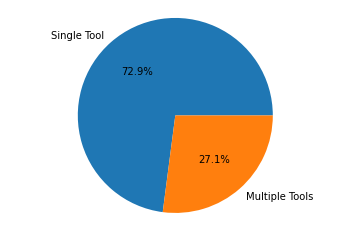

The most frequent combination of tools appearing in the same frame is ['suction', 'spatula_dissector'], and the corresponding tool keys are [1, 6]


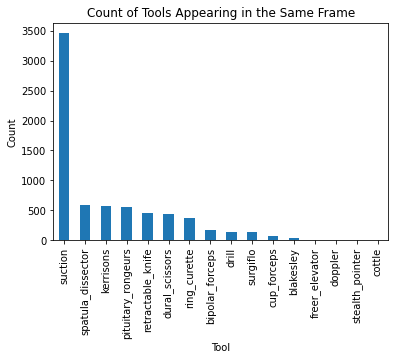

The number of occurrences of each tool in the same frame:
suction               3465
spatula_dissector      583
kerrisons              574
pituitary_rongeurs     545
retractable_knife      454
dural_scissors         441
ring_curette           361
bipolar_forceps        165
drill                  143
surgiflo               136
cup_forceps             74
blakesley               32
freer_elevator           4
doppler                  4
stealth_pointer          4
cottle                   1
Name: tool, dtype: int64
The number of occurrences of each tool in all frames:
suction               8670
kerrisons             6419
pituitary_rongeurs    2153
retractable_knife     1889
freer_elevator        1810
spatula_dissector     1039
dural_scissors         947
stealth_pointer        556
surgiflo               495
cup_forceps            464
ring_curette           414
cottle                 312
bipolar_forceps        220
drill                  217
blakesley              115
doppler                 97

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read CSV data
df = pd.read_csv("G:\Final_Data\segmentation\points_clean_none_removed.csv")

# Merge 'kerrisons_upcut' and 'kerrisons_downcut'
df.loc[df['tool'].isin(['kerrisons_upcut', 'kerrisons_downcut']), 'tool'] = 'kerrisons'

# Exclude 'tool_key 18'
df = df[df['tool_key'] != 18]

# Create a new column marking each unique combination of video, clip and second
df['video_clip_sec'] = df['video'].astype(str) + "_" + df['clip'].astype(str) + "_" + df['sec'].astype(str)

# Calculate the occurrence of each unique combination of video, clip and second
df['counts'] = df.groupby('video_clip_sec')['video_clip_sec'].transform('count')

# Find those frames where multiple tools appeared at the same second
multiple_tools_frame = df[df['counts'] > 1]

# Calculate the count and percentage of such frames
num_multiple_tools_frame = len(multiple_tools_frame)
total_frame = len(df)
percentage = num_multiple_tools_frame / total_frame * 100

print(f"{num_multiple_tools_frame} frames contain multiple tools, accounting for {percentage:.2f}% of total frames")

# Plot a pie chart
labels = ['Single Tool', 'Multiple Tools']
sizes = [total_frame - num_multiple_tools_frame, num_multiple_tools_frame]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

# Find the type of tools appearing in the same frame
tools_in_frame = multiple_tools_frame.groupby('video_clip_sec')['tool'].apply(list).reset_index()
tools_in_frame['tool_key'] = multiple_tools_frame.groupby('video_clip_sec')['tool_key'].apply(list).reset_index()['tool_key']

# Calculate the most frequent combination of tools
most_frequent_tools = tools_in_frame['tool'].value_counts().idxmax()
most_frequent_tool_keys = tools_in_frame['tool_key'].value_counts().idxmax()

print(f"The most frequent combination of tools appearing in the same frame is {most_frequent_tools}, and the corresponding tool keys are {most_frequent_tool_keys}")

# Calculate the number of occurrences of each tool in the same frame, and draw a bar chart
tool_counts = multiple_tools_frame['tool'].value_counts()
tool_counts.plot(kind='bar')
plt.xlabel('Tool')
plt.ylabel('Count')
plt.title('Count of Tools Appearing in the Same Frame')
plt.show()

# Print out the specific counts
print('The number of occurrences of each tool in the same frame:')
print(tool_counts)

# Calculate the number of occurrences of each tool in all frames
all_tool_counts = df['tool'].value_counts()

# Print out the specific counts
print('The number of occurrences of each tool in all frames:')
print(all_tool_counts)

# Make comparisons
comparison = pd.DataFrame({'Count in the Same Frame': tool_counts, 'Count in All Frames': all_tool_counts})
comparison['Percentage in the Same Frame'] = comparison['Count in the Same Frame'] / comparison['Count in All Frames'] * 100

print('Compare the count of each tool appearing in the same frame with that in all frames:')
print(comparison)

# Create a new column representing the combination of tools appearing in the same frame
tools_in_frame['tool_combination'] = tools_in_frame['tool'].apply(lambda x: tuple(sorted(x)))

# For each tool, find the tool that appears most frequently with it
tool_combinations_counts = tools_in_frame['tool_combination'].value_counts()

for tool in tool_counts.index:
    max_count = 0
    max_combination = None
    for combination, count in tool_combinations_counts.items():
        if tool in combination and count > max_count:
            max_count = count
            max_combination = combination
    other_tools = [t for t in max_combination if t != tool]
    print(f"The tool {tool} most frequently appears with {other_tools}, with a frequency of {max_count} times.")

In [ ]:
import pandas as pd

# 提取视频编号的函数
def extract_video_numbers(video_list):
    return [video.replace('video', '') for video in video_list]

# 建立数据集和视频编号的映射
datasets = {
    'training': extract_video_numbers(['video01', 'video04', 'video05', 'video06', 'video07', 'video08', 'video10', 'video11', 
                                       'video13', 'video14', 'video16', 'video18', 'video19', 'video20', 'video21', 'video22', 
                                       'video24', 'video26', 'video29', 'video33', 'video34', 'video35', 'video37', 'video39', 
                                       'video41', 'video43', 'video47', 'video49', 'video50', 'video51', 'video52', 'video53', 
                                       'video54', 'video55', 'video57']),
    'testing': extract_video_numbers(['video09', 'video15', 'video17', 'video23', 'video30', 'video31', 'video44', 'video48', 
                                      'video56', 'video58']),
    'validation': []
}

# 创建表格
df = pd.DataFrame([(dataset, video) for dataset, videos in datasets.items() for video in videos], 
                  columns=['dataset', 'video'])

# 导出为CSV文件
df.to_csv("dataset_videos.csv", index=False)


print(df)

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = r"G:\baseline\Binary_result\SAM\test_result1 (1)\test_result1\binary_mask\video01_clip01_step1_023_mask.png"
img = Image.open(img_path)
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
import os
import numpy as np
import cv2
from sklearn.metrics import precision_score, recall_score

def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    if img is None:
        print(f"无法加载图片: {image_path}")
        return None
    return img / 255

def calculate_metrics(mask, prediction):
    mask_flat = mask.flatten()
    prediction_flat = prediction.flatten()
    iou_score = np.sum(np.logical_and(mask_flat, prediction_flat)) / np.sum(np.logical_or(mask_flat, prediction_flat))
    pixel_accuracy = np.mean(mask_flat == prediction_flat)
    precision = precision_score(mask_flat, prediction_flat)
    recall = recall_score(mask_flat, prediction_flat)
    return iou_score, pixel_accuracy, precision, recall

def calculate_metrics_over_dir(groundtruth_dir, prediction_dir):
    iou_total = 0
    pa_total = 0
    precision_total = 0
    recall_total = 0
    num_images = 0

    for filename in os.listdir(groundtruth_dir):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            groundtruth = load_image(os.path.join(groundtruth_dir, filename))
            prediction = load_image(os.path.join(prediction_dir, filename.replace(".png", "_mask.png")))
            if groundtruth is None or prediction is None:
                continue
            iou_score, pixel_accuracy, precision, recall = calculate_metrics(groundtruth, prediction)
            print(f"For image {filename}, IoU: {iou_score}, Pixel Accuracy: {pixel_accuracy}, Precision: {precision}, Recall: {recall}")
            iou_total += iou_score
            pa_total += pixel_accuracy
            precision_total += precision
            recall_total += recall
            num_images += 1

    miou = iou_total / num_images
    mpa = pa_total / num_images
    avg_precision = precision_total / num_images
    avg_recall = recall_total / num_images
    return miou, mpa, avg_precision, avg_recall

def load_image(image_path, reverse=False):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if reverse:
        _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    else:
        _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    if img is None:
        print(f"无法加载图片: {image_path}")
        return None
    return img / 255

def calculate_metrics_over_dir(groundtruth_dir, prediction_dir):
    iou_total = [0, 0]
    pa_total = [0, 0]
    precision_total = [0, 0]
    recall_total = [0, 0]
    num_images = 0

    for filename in os.listdir(groundtruth_dir):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            for i, reverse in enumerate([False, True]):
                groundtruth = load_image(os.path.join(groundtruth_dir, filename), reverse=reverse)
                prediction = load_image(os.path.join(prediction_dir, filename.replace(".png", "_mask.png")), reverse=reverse)
                if groundtruth is None or prediction is None:
                    continue
                iou_score, pixel_accuracy, precision, recall = calculate_metrics(groundtruth, prediction)
                print(f"For image {filename} with {'background' if reverse else 'foreground'}, IoU: {iou_score}, Pixel Accuracy: {pixel_accuracy}, Precision: {precision}, Recall: {recall}")
                iou_total[i] += iou_score
                pa_total[i] += pixel_accuracy
                precision_total[i] += precision
                recall_total[i] += recall
            num_images += 1

    miou = [iou_total[0] / num_images, iou_total[1] / num_images]
    mpa = [pa_total[0] / num_images, pa_total[1] / num_images]
    avg_precision = [precision_total[0] / num_images, precision_total[1] / num_images]
    avg_recall = [recall_total[0] / num_images, recall_total[1] / num_images]
    return miou, mpa, avg_precision, avg_recall


if __name__ == "__main__":
    groundtruth_dir = r"G:\baseline\Binary_result\SAM\test_result1 (1)\test_result1\ground_truth"
    prediction_dir = r"G:\baseline\Binary_result\SAM\test_result1 (1)\test_result1\binary_mask"
    miou, mpa, avg_precision, avg_recall = calculate_metrics_over_dir(groundtruth_dir, prediction_dir)
    print(f"Mean Intersection over Union: {miou}")
    print(f"Mean Pixel Accuracy: {mpa}")
    print(f"Average Precision: {avg_precision}")
    print(f"Average Recall: {avg_recall}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(metrics, labels, title):
    # 设置每个柱状图的宽度
    width = 0.6

    # 定义标签位置
    label_loc = np.arange(len(labels))

    # 创建一个绘图对象
    fig, ax = plt.subplots()

    # 绘制柱状图，'#0000FF'表示饱和的蓝色
    rect = ax.barh(label_loc, metrics, width, color='#0000FF', edgecolor='black')

    # 为y轴添加标签，这里使用了你提供的标签
    ax.set_yticks(label_loc)
    ax.set_yticklabels(labels)

    # 为每个柱状图添加值标签
    for i in range(len(rect)):
        ax.text(rect[i].get_width(), rect[i].get_y() + rect[i].get_height()/2., '%.3f' % metrics[i], ha='left', va='center')

    # 添加图标题
    ax.set_title(title)

    # 显示图形
    plt.show()

if __name__ == "__main__":
    miou = [0.7860715843640592, 0.9732470783230421]
    mpa = [0.9755939398871526, 0.9755939398871526]
    avg_precision = [0.8326234124772416, 0.9944808583879845]
    avg_recall = [0.9396259596610231, 0.9785763666957084]

    labels = ['Background', 'Foreground']

    plot_metrics(miou, labels, "Mean Intersection over Union")
    plot_metrics(mpa, labels, "Mean Pixel Accuracy")
    plot_metrics(avg_precision, labels, "Average Precision")
    plot_metrics(avg_recall, labels, "Average Recall")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 图片路径
img_path1 = r"C:\Users\Tian\Desktop\video35_clip05_step5_086_predited.jpg"
img_path2 = r"C:\Users\Tian\Desktop\video35_clip05_step5_086_ground_truth.png"
img_path3 = r"C:\Users\Tian\Desktop\video35_clip05_step5_086_image.jpg"


# 读取图片
img1 = mpimg.imread(img_path1)
img2 = mpimg.imread(img_path2)
img3 = mpimg.imread(img_path3)

# 创建新的图形，设置尺寸
plt.figure(figsize=(15, 5))

# 添加三个子图
plt.subplot(1, 3, 1)  # 1行，3列，第1个
plt.imshow(img1)
plt.axis('off')  # 不显示坐标轴
plt.title('image')

plt.subplot(1, 3, 2)  # 1行，3列，第2个
plt.imshow(img2)
plt.axis('off')
plt.title('predicted')

plt.subplot(1, 3, 3)  # 1行，3列，第3个
plt.imshow(img3)
plt.axis('off')
plt.title('ground truth')

# 保存图片
plt.savefig("C:\\Users\\Tian\\Desktop\\combined_image.jpg")

plt.show()

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 目标图像路径
image_path = r"C:\Users\Tian\Desktop\video52_clip04_step4_051.jpg"

# 读取图像并获取其大小
image = cv2.imread(image_path)
height, width, _ = image.shape

# 创建一个空白的mask，大小与目标图像相同
mask = np.zeros((height, width), dtype=np.uint8)

# 给出的点坐标
points_data = {
    "2": "830.64,674.61;701.36,412.33;699.13,409.35;697.64,407.87;697.64,405.64;699.13,402.67;700.61,398.21;700.61,395.24;699.87,392.27;697.64,389.29;694.67,386.32;692.44,384.84;689.47,384.09;685.01,383.35;682.78,384.09;680.55,384.84;677.58,386.32;674.61,388.55;650.00,425.80;649.35,460.62;712.50,716.96;725.88,714.73;748.17,709.53;771.20,703.59;803.15,689.47",
    "1": "712.60,716.40;640.10,424.42;637.52,420.81;635.46,418.23;633.39,416.17;630.30,414.62;627.20,413.07;623.07,412.04;619.46,411.01;613.27,411.52;608.11,412.04;602.43,413.59;598.82,415.13;595.10,419.00;517.30,701.50;536.39,707.18;586.90,720.00;697.40,720.00"
}

for tool_key, points_str in points_data.items():
    points = []
    points_str_list = points_str.split(";")
    for point_str in points_str_list:
        x, y = map(float, point_str.split(","))
        points.append([int(x), int(y)])

    # 使用OpenCV的fillPoly函数来填充多边形
    cv2.fillPoly(mask, np.array([points], dtype=np.int32), int(tool_key))

# 显示mask
plt.imshow(mask)
plt.show()

# 检查是否有重叠
overlap = np.any(mask == 3)
if overlap:
    print("存在重叠区域")
else:
    print("不存在重叠区域")

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
import cv2

def get_image_size(image_path):
    image = cv2.imread(image_path)
    return image.shape if image is not None else None

def compare_image_sizes(image_path1, image_path2):
    image_size1 = get_image_size(image_path1)
    image_size2 = get_image_size(image_path2)

    if image_size1 is None:
        print(f"无法读取图像：{image_path1}")
    if image_size2 is None:
        print(f"无法读取图像：{image_path2}")

    if image_size1 == image_size2:
        print("两图像尺寸一样")
    else:
        print("两图像尺寸不一样")

    print(f"图像1尺寸：{image_size1}")
    print(f"图像2尺寸：{image_size2}")

if __name__ == "__main__":
    image_path1 = "G:/Final_Data/images_binary_masks/video24_clip05_step5/video24_clip05_step5_015.png"
    image_path2 = "G:/Final_Data/segmentation/images/video24_clip05_step5/video24_clip05_step5_015.jpg"
    compare_image_sizes(image_path1, image_path2)

In [ ]:
import os
import glob

def count_images(dir_path):
    total = 0
    # 遍历所有的子目录
    for root, dirs, files in os.walk(dir_path):
        # 查找每个子目录中的jpg图片
        for file in files:
            if file.endswith(".jpg"):
                total += 1
    return total

dir_path = r"G:\Final_Data\segmentation\images"
print("总共有{}张jpg图片。".format(count_images(dir_path)))

In [ ]:
import holoviews as hv
import pandas as pd
from holoviews import opts, dim
from bokeh.palettes import Category20

# Initialize Holoviews with Bokeh
hv.extension('bokeh')

# 加载数据（这里您应该使用您自己的CSV文件路径）
df = pd.read_csv(r"G:\baseline\Swin\polyp-seg\processed_csv.csv")

# 数据准备（跟之前的数据处理步骤一样）
from collections import defaultdict
cooccurrence = defaultdict(int)
for _, group_df in df.groupby(['video', 'clip']):
    tools_in_group = group_df['tool'].unique()
    for i in range(len(tools_in_group)):
        for j in range(i+1, len(tools_in_group)):
            tool1, tool2 = sorted([tools_in_group[i], tools_in_group[j]])
            cooccurrence[(tool1, tool2)] += 1

cooccurrence_df = pd.DataFrame(list(cooccurrence.items()), columns=['Tool_Pair', 'Frequency'])
cooccurrence_df['Tool1'] = cooccurrence_df['Tool_Pair'].apply(lambda x: x[0])
cooccurrence_df['Tool2'] = cooccurrence_df['Tool_Pair'].apply(lambda x: x[1])
cooccurrence_df.drop(columns=['Tool_Pair'], inplace=True)

# 创建弦图
nodes = hv.Dataset(pd.DataFrame(list(set(cooccurrence_df['Tool1']).union(set(cooccurrence_df['Tool2']))), columns=['Tool']), 'Tool')
chord = hv.Chord((cooccurrence_df, nodes), ['Tool1', 'Tool2'], ['Frequency'])

# 设置弦图选项
chord.opts(
    opts.Chord(cmap=Category20[20], edge_color=dim('Tool1').str(), height=800, 
               labels='Tool', node_color=dim('Tool').str(), width=800,
               title="Tool Co-occurrence in Videos and Clips")
)


In [ ]:
import os

# 文件夹路径
folder1 = 'G:\\Final_Data\\segmentation\\New_data\\coco\\val2017'
folder2 = r'G:\baseline\mmdetection_mask_new_dataset\mmdetection_mask\coco_seg\val'

# 计算文件数量
num_files_folder1 = len(os.listdir(folder1))
num_files_folder2 = len(os.listdir(folder2))

# 输出文件数量
print('文件夹 "{}" 中的文件数量: {}'.format(folder1, num_files_folder1))
print('文件夹 "{}" 中的文件数量: {}'.format(folder2, num_files_folder2))

# 比较文件数量
if num_files_folder1 > num_files_folder2:
    print('文件夹 "{}" 中的文件数量多于文件夹 "{}"'.format(folder1, folder2))
elif num_files_folder1 < num_files_folder2:
    print('文件夹 "{}" 中的文件数量多于文件夹 "{}"'.format(folder2, folder1))
else:
    print('两个文件夹中的文件数量相同')

In [ ]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

# Load the images
img_paths = [
    "C:\\Users\\Tian\\Desktop\\Binary_vis\\Image.jpg",
    "C:\\Users\\Tian\\Desktop\\Binary_vis\\Groundtruth.png",
    "C:\\Users\\Tian\\Desktop\\Binary_vis\\Unet.jpg",
    "C:\\Users\\Tian\\Desktop\\Binary_vis\\SAM.png",
    "C:\\Users\\Tian\\Desktop\\Binary_vis\\maskrcnn.png",
    "C:\\Users\\Tian\\Desktop\\Binary_vis\\Image(2).jpg",
    "C:\\Users\\Tian\\Desktop\\Binary_vis\\Groundtruth (2).png",
    "C:\\Users\\Tian\\Desktop\\Binary_vis\\Unet (2).jpg",
    "C:\\Users\\Tian\\Desktop\\Binary_vis\\SAM(1).png",
    "C:\\Users\\Tian\\Desktop\\Binary_vis\\maskrcnn (2).png"
]

# Create a blank white image to serve as the base
first_img = Image.open(img_paths[0])
width, height = first_img.size

# Calculate new dimensions
new_width = width * 5
new_height = height * 2
canvas = Image.new("RGB", (new_width, new_height + 100), "white")

draw = ImageDraw.Draw(canvas)
# Since your environment might not have the specified font, we'll use a default font
font = ImageFont.load_default()

# Titles
titles = ["Image", "Groundtruth", "Unet", "SAM", "MaskRCNN"]
for idx, title in enumerate(titles):
    text_position = (width * idx + width // 2 - draw.textsize(title)[0] // 2, 20)
    draw.text(text_position, title, font=font, fill=(0, 0, 0))

# Paste the images onto the canvas
for col in range(5):
    for row in range(2):
        img = Image.open(img_paths.pop(0))
        canvas.paste(img, (width * col, height * row + 100))

# Show the final image
plt.imshow(np.array(canvas))
plt.axis('off')
plt.show()
